In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torchvision
import torchvision.transforms as transforms

import ot

In [3]:
dataset = get_dataset(dataset="poverty", download=True)

In [13]:
# Get the training set
train_data = dataset.get_subset(
    "train",
)
valid_data = dataset.get_subset(
    "val",
)

In [14]:
train_loader = get_train_loader("standard", train_data, batch_size=64)
valid_loader = get_train_loader("standard", valid_data, batch_size=64)

In [15]:
with open("./data/poverty_v1.1/dhs_incountry_folds.pkl", 'rb') as file:
    folds = pickle.load(file)

In [16]:
_y = np.array([])
for i, data in enumerate(train_loader, 0):
    images, labels, meta = data
    
    _y = np.append(_y, labels)
    
_y.shape

(9797,)

In [17]:
_mean = _y.mean()
_mean

0.1226555598191669

In [18]:
_var = _y.var()
_var

0.6560673337806222

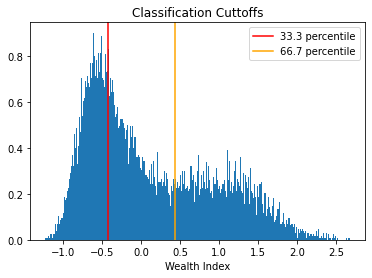

In [19]:
lower_percentile = 33.333333
upper_percentile = 66.666667

lower_cutoff = np.percentile(_y, lower_percentile)
upper_cutoff = np.percentile(_y, upper_percentile)

plt.hist(_y, bins=300, density=True)
plt.axvline(x=lower_cutoff, color='red', label=f'{round(lower_percentile, 1)} percentile')
plt.axvline(x=upper_cutoff, color='orange', label=f'{round(upper_percentile, 1)} percentile')
plt.legend()
plt.title("Classification Cuttoffs")
plt.xlabel("Wealth Index")
plt.show()

In [20]:
# construct new y for classification task
y_clf = np.where(_y < lower_cutoff, 0, np.where(_y > upper_cutoff, 2, 1))

In [21]:
%%time

import torch.nn as nn
import torch.nn.functional as F

# Neural Net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(8, 48, 3)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.conv3 = nn.Conv2d(96, 1, 1)
        
        self.fc1 = nn.Linear(2916, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x, meta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# put NN on GPU
if torch.cuda.is_available():
    net = net.cuda()
    
    
# Loss Function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training Loop
train_losses = []
valid_losses = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    count = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels, meta = data
        
        # classification labels based off of cutoffs
        labels = torch.where(labels < lower_cutoff, 0, torch.where(labels > upper_cutoff, 2, 1)).flatten()
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images, meta)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        count += 1
    # append statistics
    train_losses.append(running_loss / float(count))
    
    # validation
    with torch.no_grad():
        running_loss = 0.0
        count = 0
        for i, data in enumerate(valid_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images, labels, meta = data

            # classification labels based off of cutoffs
            labels = torch.where(labels < lower_cutoff, 0, torch.where(labels > upper_cutoff, 2, 1)).flatten()

            # put data onto gpu if available
            if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
    
            # forward
            outputs = net(images, meta)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            count += 1
    # append statistics
    valid_losses.append(running_loss / float(count))
    
    # print statistics
    print(f'[{epoch + 1}] train loss: {train_losses[-1]:.3f} valid loss: {valid_losses[-1]:.3f}')

print('Finished Training')

[1] train loss: 1.100 valid loss: 1.092
[2] train loss: 1.099 valid loss: 1.092
[3] train loss: 1.012 valid loss: 0.975
[4] train loss: 0.912 valid loss: 0.920
[5] train loss: 0.872 valid loss: 0.890
[6] train loss: 0.844 valid loss: 0.854
[7] train loss: 0.831 valid loss: 0.854
[8] train loss: 0.818 valid loss: 0.830
[9] train loss: 0.806 valid loss: 0.835
[10] train loss: 0.796 valid loss: 0.830
Finished Training
CPU times: user 1h 16min 59s, sys: 8min 20s, total: 1h 25min 20s
Wall time: 28min


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels, meta = data

        labels = torch.where(labels < lower_cutoff, 0, torch.where(labels > upper_cutoff, 2, 1)).flatten()

        if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()

        outputs = net(images, meta)

        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.shape[0]

train_acc = correct/float(total)
train_acc

0.632438501582117

In [87]:
val_data = dataset.get_subset(
    "val",
)

In [88]:
val_loader = get_train_loader("standard", val_data, batch_size=64)

In [90]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels, meta = data

        labels = torch.where(labels < lower_cutoff, 0, torch.where(labels > upper_cutoff, 2, 1)).flatten()

        if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()

        outputs = net(images, meta)

        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.shape[0]

val_acc = correct/float(total)
val_acc

0.6022000511639806

In [145]:
def get_samples(loader, samples_per_batch=10):
    samples = torch.tensor([])
    for images, _, _ in loader:
        s = torch.transpose(images, 0, 1).flatten(start_dim=1, end_dim=3)
        idx = np.random.randint(low=0, high=s.shape[1], size=samples_per_batch)
        samples = torch.cat((samples, s[:, idx]), dim=1)
    return samples

In [108]:
t_s = get_samples(train_loader)
t_s.shape

torch.Size([8, 1540])

In [109]:
v_s = get_samples(val_loader)
v_s.shape

tensor([[ 0.4762, -0.0625,  0.8775,  ..., -0.1912, -0.2261, -0.4136],
        [-0.0257,  0.5217,  1.1537,  ...,  0.1531, -0.5464, -0.3801],
        [-0.0359,  0.1682,  1.2895,  ...,  0.4898, -0.1680, -0.1447],
        ...,
        [-0.7158,  0.0167,  1.3538,  ...,  0.2377,  1.1794,  0.5167],
        [-1.6562, -0.3955,  0.2667,  ...,  0.2593, -0.5142, -0.4845],
        [ 7.7032, -0.2047,  0.6873,  ..., -0.2101,  0.3300, -0.2128]])

In [112]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=t_s, Xt=v_s)

/home/llloyd/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [114]:
v_s.shape

torch.Size([8, 1540])

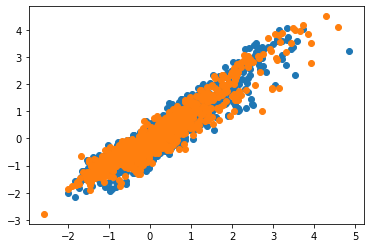

In [146]:
ids = (0, 1)
plt.scatter(t_s[ids[0], :].numpy(), t_s[ids[1], :].numpy())
plt.scatter(v_s[ids[0], :].numpy(), v_s[ids[1], :].numpy())
plt.show()

In [147]:
meta = pd.read_csv("./data/poverty_v1.1/dhs_metadata.csv")

In [151]:
c0 = meta[meta['country'] == 'angola'].index.values

In [160]:
X = np.array([])
y = np.array([])
for i in c0:
    img = np.load(f'./data/poverty_v1.1/images/landsat_poverty_img_{i}.npz')
    X = np.append(X, img['x'])
    

In [161]:
X

array([-0.420178  , -0.420178  , -1.00248623, ..., -0.22900291,
       -0.22900291, -0.22900291])

In [162]:
224*224*8

401408